Мы используем датасет из этой статьи https://pubs.acs.org/doi/10.1021/acs.jcim.8b00542. В нем находится 1000 молекул разделенных на 10 групп в зависимости от их воздействия на определенные биологические мишени.

In [25]:
!pip install umap-learn -q
!pip install rdkit

In [2]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN, KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import umap.umap_ as umap
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px
from ipywidgets import interact

In [3]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit import DataStructs

import numpy as np
import pandas as pd
from tqdm import tqdm

In [4]:
df = pd.read_csv('/content/bender.smi', sep=' ', header=None)
df.columns = ['smiles', 'classes']
df.classes = df.classes.str[:-4]

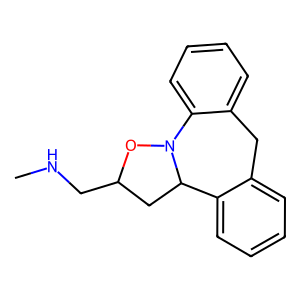

In [6]:
# Convert the SMILES string to an RDKit molecule object
mol = Chem.MolFromSmiles(df["smiles"][0])
# Draw the molecule
Draw.MolToImage(
    mol, size=(300, 300), kekulize=True, wedgeBonds=True, bgcolor=(255, 255, 255)
)

In [7]:
def smiles_to_morgan(smiles, radius=3, nBits=8192):
    # Convert the SMILES string to an RDKit molecule object
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        print("Could not parse SMILES string:", smiles)
        raise ValueError("Could not parse SMILES string:", smiles)
    # Generate the Morgan fingerprint for the molecule
    fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits)
    # Convert the fingerprint to a numpy array and return it
    fingerprint_array = np.zeros((0,), dtype=int)
    DataStructs.ConvertToNumpyArray(fingerprint, fingerprint_array)
    return fingerprint_array


# Обрабатываем все smiles из датасета и превращаем их в фингерпринты
c = []
labels = []
for sm, activity in tqdm(zip(df["smiles"].values, df["classes"].values)):
    try:
        mol = Chem.MolFromSmiles(sm)
        # SMILES --> fingerprints
        fingerprint = smiles_to_morgan(sm)
        fingerprints.append(fingerprint)
        labels.append(activity)
    except:
        pass

1000it [00:01, 819.22it/s]


In [29]:
n_neighbors = 100
min_dist = 0.7
n_components = 2
metric = "euclidean"

In [30]:
sc = MinMaxScaler(feature_range=(0, 1))
X = fingerprints
X = sc.fit_transform(X)
reducer = umap.UMAP(
    n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components, metric=metric
)
data = pd.DataFrame(reducer.fit_transform(X), columns=["Component_1", "Component_2"])

In [31]:
data["labels"] = labels
data["smiles"] = df["smiles"]

In [32]:
data

,Component_1,Component_2,labels,smiles
0,-5.512481,-9.814485,A2a,CNCC1CC2c3ccccc3Cc3ccccc3N2O1
1,-5.690169,-10.304127,A2a,CN(C)CC1CC2c3ccccc3Cc3ccccc3N2O1
2,-5.357732,-10.458628,A2a,CN1CCN2c3ccccc3Cc3ccccc3C2C1
3,-5.840332,-10.486240,A2a,CN(C)CC1CC2c3ccccc3Cc3ccc(Cl)cc3N2O1
4,-5.470594,-9.166525,A2a,CC(N)Cc1c[nH]c2ccc3c(c12)CCCO3
...,...,...,...,...
995,0.004430,-9.631836,Caspase,CC(C)CC(NC(=O)Cc1ccc(-c2ccccc2)cc1)C(=O)NC1CC(...
996,-0.346372,-9.634485,Caspase,CC(C)CC(NC(=O)CCCc1ccc2ccccc2c1)C(=O)NC1CC(=O)...
997,0.059276,-9.470079,Caspase,CC(C)CC(NC(=O)COc1cccc2cccnc12)C(=O)NC1CC(=O)OC1O
998,-0.141534,-8.898733,Caspase,CC(C)CC(NC(=O)CC(=O)c1cccc2ccccc12)C(=O)NC1CC(...


In [12]:
fig = px.scatter(
    data,
    x="Component_1",
    y="Component_2",
    color="labels",
    width=1200,
    height=800,
    hover_name="smiles",
)
fig.show()

In [48]:
kmeans = KMeans(n_clusters=10, random_state=0, n_init="auto")
data["pred_labels"] = kmeans.fit_predict(X)

In [49]:
fig = px.scatter(
    data,
    x="Component_1",
    y="Component_2",
    color="pred_labels",
    width=1200,
    height=800,
    hover_name="smiles",
)
fig.show()

In [50]:
unique_targets = data.labels.unique()
num_targets = len(unique_targets)
target_dict = dict([(x, y) for x, y in zip(unique_targets, range(0, num_targets))])
target_dict

{'A2a': 0,
 'ABL1': 1,
 'Acetylcholinesterase': 2,
 'Aurora-A': 3,
 'B-raf': 4,
 'COX-1': 5,
 'COX-2': 6,
 'Cannabinoid': 7,
 'Carbonic': 8,
 'Caspase': 9}

In [51]:
df["pred_labels"] = data["pred_labels"]

In [52]:
df.sort_values("pred_labels", inplace=True)

In [53]:
unique_targets = df.classes.unique()
target_dict = dict(
    [(x, y) for x, y in zip(unique_targets, range(0, len(unique_targets)))]
)
num_targets = len(unique_targets)
target_dict

{'COX-1': 0,
 'COX-2': 1,
 'Caspase': 2,
 'Aurora-A': 3,
 'Carbonic': 4,
 'A2a': 5,
 'B-raf': 6,
 'ABL1': 7,
 'Acetylcholinesterase': 8,
 'Cannabinoid': 9}

In [54]:
mat = []
for k, v in df.groupby("pred_labels"):
    row_vec = np.zeros(num_targets, dtype=np.int8)
    for tgt, count in v.classes.value_counts().items():
        tgt_idx = target_dict[tgt]
        row_vec[tgt_idx] = count
    mat.append(row_vec)
mat = np.array(mat)
out_df = pd.DataFrame(mat.transpose())
out_df.insert(0, "Target", unique_targets)
out_df

,Target,0,1,2,3,4,5,6,7,8,9
0,COX-1,74,0,0,0,16,0,0,0,0,10
1,COX-2,64,0,0,0,28,0,0,0,0,8
2,Caspase,21,0,0,0,74,0,0,0,5,0
3,Aurora-A,1,0,0,0,87,2,0,0,0,10
4,Carbonic,0,97,0,0,3,0,0,0,0,0
5,A2a,0,0,37,0,49,0,0,0,0,14
6,B-raf,0,0,0,37,2,2,41,0,0,18
7,ABL1,0,0,0,18,15,42,2,0,22,1
8,Acetylcholinesterase,0,0,0,0,82,0,0,0,0,18
9,Cannabinoid,0,0,0,0,2,0,0,78,0,20


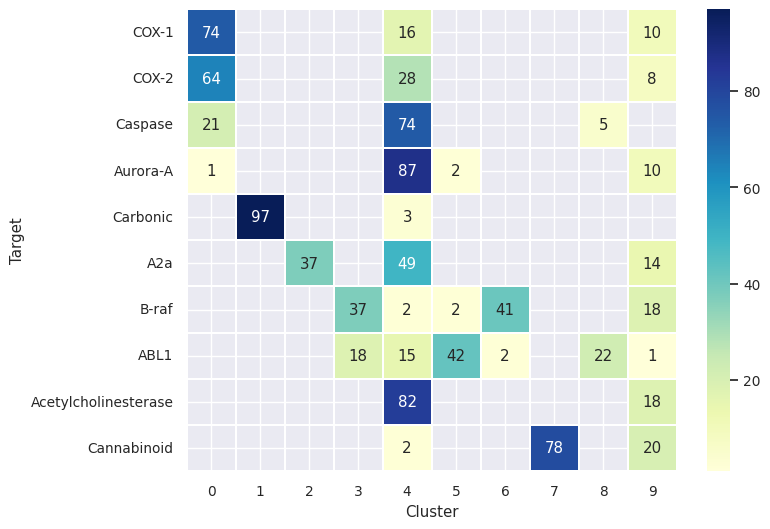

In [55]:
sns.set_theme(rc={"figure.figsize": (7.9, 6)})
sns.set_theme(font_scale=0.9)
hm_df = pd.DataFrame(np.array(out_df.values[0::, 1::], dtype=np.int8))
hm_df.replace(0, np.nan, inplace=True)

ax = sns.heatmap(
    hm_df, annot=True, yticklabels=unique_targets, linewidths=0.25, cmap="YlGnBu"
)
settings = ax.set(xlabel="Cluster", ylabel="Target")

In [56]:
def display_mols(target):
    sel = df.query(f"classes == '{target}'")
    smi_list = list(sel.smiles)
    cluster_list = [str(x) for x in sel.pred_labels]
    display(
        Draw.MolsToGridImage(
            [Chem.MolFromSmiles(x) for x in smi_list], legends=cluster_list, maxMols=10
        )
    )

In [57]:
res = interact(display_mols, target=unique_targets)

interactive(children=(Dropdown(description='target', options=('COX-1', 'COX-2', 'Caspase', 'Aurora-A', 'Carbon…

In [58]:
dbscan = DBSCAN(eps=7, min_samples=5).fit(fingerprints)
data["pred_labels"] = dbscan.labels_

In [59]:
fig = px.scatter(
    data,
    x="Component_1",
    y="Component_2",
    color="pred_labels",
    width=1200,
    height=800,
    hover_name="smiles",
)
fig.show()